# Equilibrium Model: Implementation

This notebook implements the equilibrium conditions model step by step, following the algorithm in the document.

## Model Components:
1. Reservation-Value HJB
2. Optimality: Maintenance FOC
3. Stationary Kolmogorov-Forward Equations
4. Solution Algorithm (Policy–HJB–KFE Fixed Point)

## Fast Parameters (for debugging):
- Grid sizes: N_q=30, N_delta=20 (reduced for speed)
- Parameters can be adjusted in Step 1


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully")


Libraries imported successfully


## Step 1: Parameter Setup and Grid Discretization

Following Section 1 of the Appendix, we set up uniform grids for quality $q$ and type $\delta$.


In [35]:
# Parameters (fast for debugging)
r = 0.05          # Discount rate
gamma = 0.1       # Type reset rate
rho = 0.5         # Meeting rate
d = 0.02          # Depreciation rate
s_owner = 0.6     # Stock of owners (mass constraint) - using s_owner to avoid conflicts
kappa_0 = 1.0     # Cost parameter for maintenance

# Alias for backward compatibility (but use s_owner explicitly)
s = s_owner

# Grid boundaries
q_min = 0.1       # Lower bound for quality
q_max = 2.0       # Upper bound for quality
delta_min = 0.1   # Lower bound for type
delta_max = 1.0   # Upper bound for type

# Grid sizes (reduced for fast debugging)
N_q = 30          # Number of quality grid points
N_delta = 20      # Number of type grid points

# Step sizes
Delta_q = (q_max - q_min) / (N_q - 1)
Delta_delta = (delta_max - delta_min) / (N_delta - 1)

# Create uniform grids
q_grid = np.linspace(q_min, q_max, N_q)
delta_grid = np.linspace(delta_min, delta_max, N_delta)

# Integration weights
w_q = Delta_q * np.ones(N_q)
w_delta = Delta_delta * np.ones(N_delta)

# Type distribution g(delta) - using uniform for simplicity
g = np.ones(N_delta) / (N_delta * Delta_delta)  # Normalized uniform

print(f"Grid setup complete:")
print(f"  Quality: {N_q} points from {q_min:.2f} to {q_max:.2f}, Δq = {Delta_q:.4f}")
print(f"  Type: {N_delta} points from {delta_min:.2f} to {delta_max:.2f}, Δδ = {Delta_delta:.4f}")
print(f"  Total grid points: {N_q * N_delta}")

# Verify grid
print(f"\nFirst few q values: {q_grid[:5]}")
print(f"First few delta values: {delta_grid[:5]}")
print(f"g(delta) sum (should be 1): {np.sum(g * w_delta):.6f}")


Grid setup complete:
  Quality: 30 points from 0.10 to 2.00, Δq = 0.0655
  Type: 20 points from 0.10 to 1.00, Δδ = 0.0474
  Total grid points: 600

First few q values: [0.1        0.16551724 0.23103448 0.29655172 0.36206897]
First few delta values: [0.1        0.14736842 0.19473684 0.24210526 0.28947368]
g(delta) sum (should be 1): 1.000000


## Step 2: Initialize State Variables

Following the initialization from Section 7 of the Appendix.


Initialization complete:
  h_0 mass: 0.400000 (should be 0.40)
  h_1 mass: 0.620690 (should be 0.60)
  Delta_v shape: (30, 20)
  Delta_v min: 0.2000, max: 40.0000
  a shape: (30, 20), all zeros: True


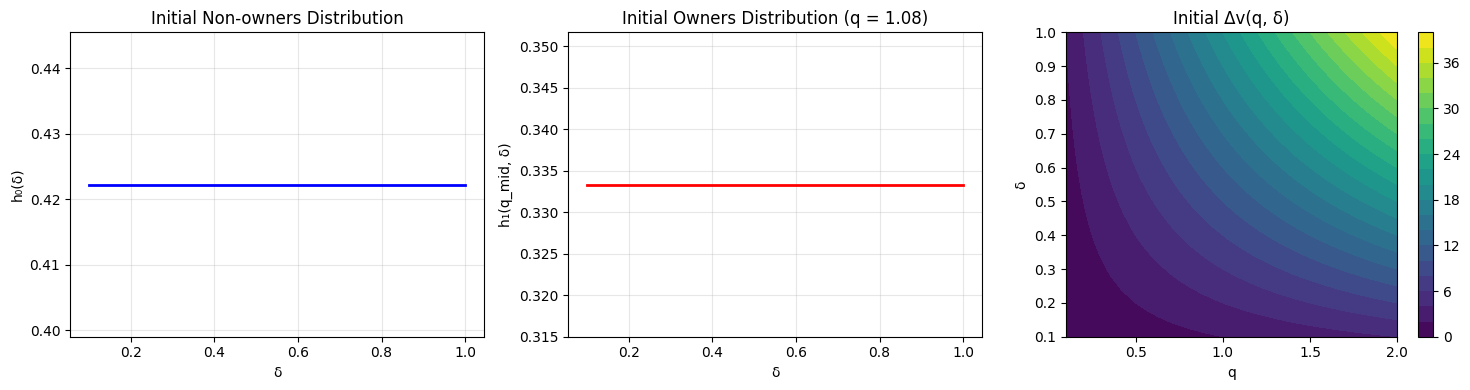

In [36]:
# Initialize h_0 (non-owners distribution)
h_0 = (1 - s) * g.copy()

# Initialize h_1 (owners distribution) - uniform over quality, g(delta) over type
h_1 = np.zeros((N_q, N_delta))
for i in range(N_q):
    h_1[i, :] = s * g / (q_max - q_min)

# Initialize maintenance policy a(q, delta)
a = np.zeros((N_q, N_delta))

# Initialize reservation value Delta v(q, delta) = v_1 - v_0
# Initial guess: Delta v = delta * q / r (no-trade benchmark)
Delta_v = np.zeros((N_q, N_delta))
for i in range(N_q):
    for j in range(N_delta):
        Delta_v[i, j] = delta_grid[j] * q_grid[i] / r

# Cost function kappa(q)
kappa = kappa_0 * q_grid

# Helper function to compute double integral
def compute_mass_h1(h_1_arr):
    """Compute ∫∫ h_1(q,δ) dq dδ"""
    return np.sum(h_1_arr * w_q[:, np.newaxis] * w_delta[np.newaxis, :])

def compute_mass_h0(h_0_arr):
    """Compute ∫ h_0(δ) dδ"""
    return np.sum(h_0_arr * w_delta)

print("Initialization complete:")
print(f"  h_0 mass: {compute_mass_h0(h_0):.6f} (should be {1-s:.2f})")
print(f"  h_1 mass: {compute_mass_h1(h_1):.6f} (should be {s:.2f})")
print(f"  Delta_v shape: {Delta_v.shape}")
print(f"  Delta_v min: {np.min(Delta_v):.4f}, max: {np.max(Delta_v):.4f}")
print(f"  a shape: {a.shape}, all zeros: {np.allclose(a, 0)}")

# Plot initial distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# h_0
axes[0].plot(delta_grid, h_0, 'b-', linewidth=2)
axes[0].set_xlabel('δ')
axes[0].set_ylabel('h₀(δ)')
axes[0].set_title('Initial Non-owners Distribution')
axes[0].grid(True, alpha=0.3)

# h_1 marginal over delta (at middle q)
mid_q_idx = N_q // 2
axes[1].plot(delta_grid, h_1[mid_q_idx, :], 'r-', linewidth=2)
axes[1].set_xlabel('δ')
axes[1].set_ylabel('h₁(q_mid, δ)')
axes[1].set_title(f'Initial Owners Distribution (q = {q_grid[mid_q_idx]:.2f})')
axes[1].grid(True, alpha=0.3)

# Delta_v surface
im = axes[2].contourf(q_grid, delta_grid, Delta_v.T, levels=20, cmap='viridis')
axes[2].set_xlabel('q')
axes[2].set_ylabel('δ')
axes[2].set_title('Initial Δv(q, δ)')
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()


## Step 3: Build Discrete Operators

Following Section 2 of the Appendix, we construct the basic discrete operators.


In [37]:
# 3.1: Upwind derivative in q (D_q)
# Following the document: forward upwind in interior, one-sided backward at upper boundary
def build_D_q_upwind():
    """Build upwind derivative matrix in q dimension."""
    # Create sparse matrix for D_q
    D_q = sparse.lil_matrix((N_q, N_q))
    
    # Interior: forward difference (upwind for negative drift)
    for i in range(N_q - 1):
        D_q[i, i] = -1.0 / Delta_q
        D_q[i, i+1] = 1.0 / Delta_q
    
    # Upper boundary: backward difference (one-sided)
    D_q[N_q-1, N_q-2] = -1.0 / Delta_q
    D_q[N_q-1, N_q-1] = 1.0 / Delta_q
    
    return D_q.tocsr()

D_q = build_D_q_upwind()
print("D_q matrix built:")
print(f"  Shape: {D_q.shape}")
print(f"  Non-zero entries: {D_q.nnz}")
print(f"  First row (should be [-1/Δq, 1/Δq, 0, ...]):")
print(f"    {D_q[0, :5].toarray()[0]}")
print(f"  Last row (backward difference):")
print(f"    {D_q[N_q-1, N_q-5:].toarray()[0]}")

# 3.2: Slope operator S = I_{N_delta} ⊗ D_q
# This applies D_q to each delta slice
S = sparse.kron(sparse.eye(N_delta), D_q)
print(f"\nS (slope operator) built:")
print(f"  Shape: {S.shape} (should be {N_q*N_delta} x {N_q*N_delta})")
print(f"  Non-zero entries: {S.nnz}")

# 3.3: Type-reset operator E_g
# E_g maps any vector to its mean w.r.t. g
E_g = np.outer(np.ones(N_delta), g * w_delta)
print(f"\nE_g (type-reset operator) built:")
print(f"  Shape: {E_g.shape}")
print(f"  Test: E_g applied to ones should give constant:")
test_vec = np.ones(N_delta)
E_g_test = E_g @ test_vec
print(f"    Result: {E_g_test[:3]} (should be constant)")

# 3.4: Triangular integrators in type
# Lower triangular: L_delta[j, s] = w_delta_s * 1_{s <= j}
L_delta = np.zeros((N_delta, N_delta))
for j in range(N_delta):
    for s in range(j + 1):
        L_delta[j, s] = w_delta[s]

# Upper triangular: U_delta[j, b] = w_delta_b * 1_{b >= j}
U_delta = np.zeros((N_delta, N_delta))
for j in range(N_delta):
    for b in range(j, N_delta):
        U_delta[j, b] = w_delta[b]

print(f"\nL_delta and U_delta built:")
print(f"  L_delta shape: {L_delta.shape}")
print(f"  U_delta shape: {U_delta.shape}")
print(f"  Test L_delta: sum of row 5 = {np.sum(L_delta[5, :]):.6f}")
print(f"  Test U_delta: sum of row 5 = {np.sum(U_delta[5, :]):.6f}")

# 3.5: Quality drift operator M_{-dq}
M_neg_dq = sparse.diags(-d * q_grid, 0)
print(f"\nM_neg_dq (quality drift operator) built:")
print(f"  Shape: {M_neg_dq.shape}")
print(f"  Diagonal entries (first 5): {[-d * q for q in q_grid[:5]]}")

# 3.6: Cost curvature K = I_{N_delta} ⊗ diag(kappa(q_i))
K = sparse.kron(sparse.eye(N_delta), sparse.diags(kappa, 0))
print(f"\nK (cost curvature) built:")
print(f"  Shape: {K.shape}")
print(f"  kappa values (first 5): {kappa[:5]}")


D_q matrix built:
  Shape: (30, 30)
  Non-zero entries: 60
  First row (should be [-1/Δq, 1/Δq, 0, ...]):
    [-15.26315789  15.26315789   0.           0.           0.        ]
  Last row (backward difference):
    [  0.           0.           0.         -15.26315789  15.26315789]

S (slope operator) built:
  Shape: (600, 600) (should be 600 x 600)
  Non-zero entries: 1200

E_g (type-reset operator) built:
  Shape: (20, 20)
  Test: E_g applied to ones should give constant:
    Result: [1. 1. 1.] (should be constant)

L_delta and U_delta built:
  L_delta shape: (20, 20)
  U_delta shape: (20, 20)
  Test L_delta: sum of row 5 = 0.284211
  Test U_delta: sum of row 5 = 0.710526

M_neg_dq (quality drift operator) built:
  Shape: (30, 30)
  Diagonal entries (first 5): [np.float64(-0.002), np.float64(-0.003310344827586207), np.float64(-0.004620689655172414), np.float64(-0.00593103448275862), np.float64(-0.007241379310344826)]

K (cost curvature) built:
  Shape: (600, 600)
  kappa values (first

## Step 4: Build HJB Operator (Linear Form with Given Policy a)

Following Section 3 of the Appendix, we construct the linear HJB operator 𝒜(a; h_0, h_1).


In [38]:
def build_D_q_upwind_state_dependent(v):
    """
    Build state-dependent upwind derivative matrix in q dimension.
    Following document: "Upwind Operator in q with Nodewise Velocity"
    
    v[i,j] = a[i,j] - d*q[i] is the velocity at each node.
    
    According to document:
    - If v_{i,j} > 0 and 1 < i <= N_q: backward difference (Δv_{i,j} - Δv_{i-1,j})/Δq
    - If v_{i,j} < 0 and 1 <= i < N_q: forward difference (Δv_{i+1,j} - Δv_{i,j})/Δq
    - At boundaries (one-sided):
      * i=1: (Δv_{2,j} - Δv_{1,j})/Δq (forward, regardless of v)
      * i=N_q: (Δv_{N_q,j} - Δv_{N_q-1,j})/Δq (backward, regardless of v)
    """
    N = N_q * N_delta
    D_up = sparse.lil_matrix((N, N))
    
    v_flat = v.flatten('F')
    
    for idx in range(N):
        j = idx // N_q
        i = idx % N_q  # i is 0-indexed, so i=0 means first point, i=N_q-1 means last point
        v_ij = v_flat[idx]
        
        # Handle boundaries first (document says one-sided formulas)
        if i == 0:  # Left boundary: i=1 in document (1-indexed)
            # One-sided forward: (Δv_{2,j} - Δv_{1,j})/Δq
            D_up[idx, idx] = -1.0 / Delta_q
            D_up[idx, idx + 1] = 1.0 / Delta_q
        elif i == N_q - 1:  # Right boundary: i=N_q in document
            # One-sided backward: (Δv_{N_q,j} - Δv_{N_q-1,j})/Δq
            D_up[idx, idx - 1] = -1.0 / Delta_q
            D_up[idx, idx] = 1.0 / Delta_q
        else:
            # Interior points: use upwind based on sign of v
            if v_ij > 0:
                # Backward difference: (Δv_{i,j} - Δv_{i-1,j})/Δq
                D_up[idx, idx - 1] = -1.0 / Delta_q
                D_up[idx, idx] = 1.0 / Delta_q
            elif v_ij < 0:
                # Forward difference: (Δv_{i+1,j} - Δv_{i,j})/Δq
                D_up[idx, idx] = -1.0 / Delta_q
                D_up[idx, idx + 1] = 1.0 / Delta_q
            else:
                # v = 0: use forward difference (safe default)
                D_up[idx, idx] = -1.0 / Delta_q
                D_up[idx, idx + 1] = 1.0 / Delta_q
    
    return D_up.tocsr()

def build_HJB_operator_discrete_form(a, h_0, h_1):
    """
    Build HJB operator using the "Discrete Linear HJB at (q_i,δ_j)" formulation from document.
    
    The equation is:
    [r+γ+(ρ/2)η_j]Δv_{i,j}
    - v_{i,j}(D_q^{up}(v)Δv)_{i,j}
    - γ∑_{k=1}^{N_δ}Δv_{i,k} g_k w^δ_k
    - (ρ/2)∑_{b=j}^{N_δ}Δv_{i,b} h_{0,b} w^δ_b
    + (ρ/2)∑_{i'=1}^{N_q} w^q_{i'} ξ_{i',j} Δv_{i',j}
    - (ρ/2)∑_{i'=1}^{N_q}∑_{s=1}^{j} w^q_{i'} h_{1,i',s} w^δ_s Δv_{i',s}
    = b^{flow}_{i,j}
    
    where:
    - v_{i,j} = a_{i,j} - d*q_i
    - η_j = ∑_{b=j}^{N_δ} h_{0,b} w^δ_b
    - ξ_{i',j} = ∑_{s=1}^{j} h_{1,i',s} w^δ_s
    """
    N = N_q * N_delta
    A = sparse.lil_matrix((N, N))
    
    # Compute velocity v = a - d*q
    v = np.zeros((N_q, N_delta))
    for i in range(N_q):
        for j in range(N_delta):
            v[i, j] = a[i, j] - d * q_grid[i]
    
    # Build state-dependent upwind operator D_q^{up}(v)
    D_up = build_D_q_upwind_state_dependent(v)
    v_vec = v.flatten('F')
    
    # Step 1: Diagonal term: r + γ + (ρ/2)η_j
    # First compute η_j = ∑_{b=j}^{N_δ} h_{0,b} w^δ_b
    eta = np.zeros(N_delta)
    for j in range(N_delta):
        eta[j] = np.sum(h_0[j:] * w_delta[j:])
    
    # Add to diagonal: r + γ + (ρ/2)η_j for each (i,j)
    for j in range(N_delta):
        for i in range(N_q):
            idx = j * N_q + i
            A[idx, idx] = r + gamma + (rho / 2) * eta[j]
    
    # Step 2: Advection term: -v_{i,j}(D_q^{up}(v)Δv)_{i,j}
    # This subtracts v * (upwind derivative)
    A -= sparse.diags(v_vec, 0) @ D_up
    
    # Step 3: Type reset: -γ∑_{k=1}^{N_δ}Δv_{i,k} g_k w^δ_k
    # Note: +γΔv_{i,j} is already in diagonal, so we subtract the full sum
    # This gives: -γ∑_k Δv_{i,k} g_k w^δ_k = -γ*E_g applied to row i
    for i in range(N_q):
        for j in range(N_delta):
            idx = j * N_q + i
            for k in range(N_delta):
                idx_k = k * N_q + i
                A[idx, idx_k] -= gamma * g[k] * w_delta[k]
    
    # Step 4: Buyer trade: -(ρ/2)∑_{b=j}^{N_δ}Δv_{i,b} h_{0,b} w^δ_b
    # For each row (i,j), subtract from columns (i,b) where b >= j
    # Note: The diagonal already has +(ρ/2)η_j where η_j = ∑_{b=j}^{N_δ} h_{0,b} w^δ_b
    # So when we subtract h_{0,b}*w_delta[b] for b=j, it cancels part of η_j
    # Net effect: diagonal gets contributions only from b>j terms (already in η_j),
    # and we subtract off-diagonal terms for b>j
    for i in range(N_q):
        for j in range(N_delta):
            idx_row = j * N_q + i  # Row index for (i,j)
            for b in range(j, N_delta):  # b from j to N_delta-1 (b >= j)
                idx_col = b * N_q + i  # Column index for (i,b)
                A[idx_row, idx_col] -= (rho / 2) * h_0[b] * w_delta[b]
    
    # Step 5: Seller trade positive: +(ρ/2)∑_{i'=1}^{N_q} w^q_{i'} ξ_{i',j} Δv_{i',j}
    # where ξ_{i',j} = ∑_{s=1}^{j} h_{1,i',s} w^δ_s
    # This adds to diagonal in δ (same j) but couples across q (all i')
    for j in range(N_delta):
        # Compute ξ_{i',j} for all i'
        xi_col_j = np.zeros(N_q)
        for i_prime in range(N_q):
            xi_col_j[i_prime] = np.sum(h_1[i_prime, :j+1] * w_delta[:j+1])
        
        # Add to A: (ρ/2) * w^q_{i'} * ξ_{i',j} * Δv_{i',j}
        for i_prime in range(N_q):
            idx = j * N_q + i_prime
            A[idx, idx] += (rho / 2) * w_q[i_prime] * xi_col_j[i_prime]
    
    # Step 6: Seller trade negative: -(ρ/2)∑_{i'=1}^{N_q}∑_{s=1}^{j} w^q_{i'} h_{1,i',s} w^δ_s Δv_{i',s}
    # For each row (i,j), subtract contributions from all columns (i',s) where s <= j
    # Note: When s=j and i'=i, this cancels with part of Step 5, leaving only s<j terms in diagonal
    for j in range(N_delta):
        for i in range(N_q):
            idx_row = j * N_q + i  # Row index for (i,j)
            for s in range(j + 1):  # s from 0 to j (0-indexed, so s <= j)
                for i_prime in range(N_q):
                    idx_col = s * N_q + i_prime  # Column index for (i',s)
                    A[idx_row, idx_col] -= (rho / 2) * w_q[i_prime] * h_1[i_prime, s] * w_delta[s]
    
    # Convert to CSR for efficient operations
    A = A.tocsr()
    
    # Sanity check: Verify diagonal is positive (should be for stability)
    diag = A.diagonal()
    min_diag = np.min(diag)
    if min_diag < 0:
        print(f"  WARNING in HJB operator: Minimum diagonal = {min_diag:.6f} < 0")
        print(f"    This may cause instability. Check implementation.")
    
    return A

def build_HJB_operator(a, h_0, h_1, use_discrete_form=True):
    """
    Build the linear HJB operator A(a; h_0, h_1).
    
    If use_discrete_form=True (default), uses the "Discrete Linear HJB" formulation
    which explicitly follows the document's equation step by step.
    
    If use_discrete_form=False, uses Appendix Section 3 formulation (alternative).
    """
    if use_discrete_form:
        return build_HJB_operator_discrete_form(a, h_0, h_1)
    else:
        # Alternative: Appendix Section 3 formulation (for comparison)
        N = N_q * N_delta
        A = sparse.lil_matrix((N, N))
        
        # 1. r * I
        A += r * sparse.eye(N)
        
        # 2. M_{-dq}D_q: -d*q * (Δv)_q (depreciation)
        M_Dq = M_neg_dq @ D_q
        A += sparse.kron(sparse.eye(N_delta), M_Dq)
        
        # 3. A_a: a * (Δv)_q (maintenance)
        a_vec = a.flatten('F')
        A_a_term = sparse.diags(a_vec, 0) @ S
        A += A_a_term
        
        # 4. Type reset: γ(I - E_g)
        I_minus_Eg = sparse.eye(N_delta) - sparse.csr_matrix(E_g)
        A += gamma * sparse.kron(sparse.eye(N_q), I_minus_Eg)
        
        # 5. Trade terms (same as before)
        eta = np.zeros(N_delta)
        for j in range(N_delta):
            eta[j] = np.sum(h_0[j:] * w_delta[j:])
        
        H = sparse.diags(eta, 0)
        U_h0 = np.zeros((N_delta, N_delta))
        for j in range(N_delta):
            for b in range(j, N_delta):
                U_h0[j, b] = h_0[b] * w_delta[b]
        
        H_minus_U = H - sparse.csr_matrix(U_h0)
        A += (rho / 2) * sparse.kron(sparse.eye(N_q), H_minus_U)
        
        # C_diag and L_h1
        Xi = np.zeros((N_q, N_delta))
        for i in range(N_q):
            for j in range(N_delta):
                Xi[i, j] = np.sum(h_1[i, :j+1] * w_delta[:j+1])
        
        for j in range(N_delta):
            for i in range(N_q):
                idx = j * N_q + i
                A[idx, idx] += (rho / 2) * w_q[i] * Xi[i, j]
        
        for j in range(N_delta):
            for s in range(j + 1):
                for i in range(N_q):
                    idx_row = j * N_q + i
                    for i_prime in range(N_q):
                        idx_col = s * N_q + i_prime
                        A[idx_row, idx_col] -= (rho / 2) * w_q[i_prime] * h_1[i_prime, s] * w_delta[s]
        
        return A.tocsr()

# Test building the operator
print("Building HJB operator...")
try:
    A_test = build_HJB_operator(a, h_0, h_1)
    print(f"HJB operator built successfully!")
    print(f"  Shape: {A_test.shape}")
    print(f"  Non-zero entries: {A_test.nnz}")
    print(f"  Sparsity: {100 * (1 - A_test.nnz / (A_test.shape[0] * A_test.shape[1])):.2f}%")
    
    # Check if matrix is reasonable
    print(f"  Diagonal entries (first 5): {A_test.diagonal()[:5]}")
    
except Exception as e:
    print(f"Error building HJB operator: {e}")
    import traceback
    traceback.print_exc()


Building HJB operator...
  WARNING in HJB operator: Minimum diagonal = -0.440613 < 0
    This may cause instability. Check implementation.
HJB operator built successfully!
  Shape: (600, 600)
  Non-zero entries: 194700
  Sparsity: 45.92%
  Diagonal entries (first 5): [0.20947368 0.18947368 0.16947368 0.14947368 0.12947368]


In [39]:
# Verify HJB operator construction
print("="*60)
print("Testing HJB Operator Construction")
print("="*60)

try:
    # Build operator with discrete form (default)
    A_test = build_HJB_operator(a, h_0, h_1, use_discrete_form=True)
    
    print(f"\n✓ HJB operator built successfully!")
    print(f"  Shape: {A_test.shape}")
    print(f"  Non-zero entries: {A_test.nnz}")
    print(f"  Sparsity: {100 * (1 - A_test.nnz / (A_test.shape[0] * A_test.shape[1])):.2f}%")
    
    # Check diagonal entries
    diag = A_test.diagonal()
    print(f"\n  Diagonal analysis:")
    print(f"    Min: {np.min(diag):.6f}, Max: {np.max(diag):.6f}, Mean: {np.mean(diag):.6f}")
    print(f"    Expected range: [{r:.4f}, {r+gamma+rho/2:.4f}] approximately")
    
    # Check for problems
    neg_diag = np.sum(diag < 0)
    if neg_diag > 0:
        print(f"    ⚠ WARNING: {neg_diag} diagonal entries are negative!")
        print(f"      This could cause instability!")
    
    very_large_diag = np.sum(np.abs(diag) > 1e6)
    if very_large_diag > 0:
        print(f"    ⚠ WARNING: {very_large_diag} diagonal entries are very large (>1e6)!")
    
    # Check a few sample entries
    print(f"\n  Sample diagonal entries (first row of each type j):")
    for j in [0, N_delta//2, N_delta-1]:
        idx = j * N_q
        print(f"    Type j={j} (δ={delta_grid[j]:.3f}): A[{idx},{idx}] = {diag[idx]:.6f}")
    
    # Test solve with simple case
    print(f"\n  Testing solve with zero policy (a=0)...")
    b_test = build_flow_term(np.zeros((N_q, N_delta)))
    try:
        Delta_v_test = spsolve(A_test, b_test)
        Delta_v_test_2d = Delta_v_test.reshape((N_q, N_delta), order='F')
        print(f"    ✓ Solve successful")
        print(f"    Solution range: [{np.min(Delta_v_test_2d):.4f}, {np.max(Delta_v_test_2d):.4f}]")
        
        # Check if solution is reasonable
        if np.any(np.isnan(Delta_v_test)) or np.any(np.isinf(Delta_v_test)):
            print(f"    ⚠ WARNING: Solution contains NaN or Inf!")
        elif np.max(np.abs(Delta_v_test)) > 1e10:
            print(f"    ⚠ WARNING: Solution has very large values!")
            print(f"      This suggests the operator may be unstable.")
        else:
            print(f"    ✓ Solution looks reasonable")
            
    except Exception as e:
        print(f"    ✗ Solve failed: {e}")
        print(f"      This indicates the operator matrix is singular or ill-conditioned.")
    
except Exception as e:
    print(f"✗ Error building HJB operator: {e}")
    import traceback
    traceback.print_exc()


Testing HJB Operator Construction
  WARNING in HJB operator: Minimum diagonal = -0.440613 < 0
    This may cause instability. Check implementation.

✓ HJB operator built successfully!
  Shape: (600, 600)
  Non-zero entries: 194700
  Sparsity: 45.92%

  Diagonal analysis:
    Min: -0.440613, Max: 0.850526, Mean: -0.084868
    Expected range: [0.0500, 0.4000] approximately
    ⚠ WARNING: 406 diagonal entries are negative!
      This could cause instability!

  Sample diagonal entries (first row of each type j):
    Type j=0 (δ=0.100): A[0,0] = 0.209474
    Type j=10 (δ=0.574): A[300,300] = 0.162060
    Type j=19 (δ=1.000): A[570,570] = 0.119387

  Testing solve with zero policy (a=0)...
    ✓ Solve successful
    Solution range: [-26.4878, -4.7618]
    ✓ Solution looks reasonable


## Step 5: Build Flow Term and Solve Linear HJB

Given policy a, we solve the linear HJB: 𝒜(a; h_0, h_1) Δ = b


Building flow term...
Flow term built:
  Shape: (600,)
  Min: 0.0100, Max: 2.0000, Mean: 0.5775

Solving linear HJB...
  WARNING in HJB operator: Minimum diagonal = -0.440613 < 0
    This may cause instability. Check implementation.
  Smallest eigenvalues (real part): [ 0.00496927 -0.00488432  0.00482933]
HJB solved successfully!
  Delta_v shape: (30, 20)
  Delta_v min: -26.4878, max: -4.7618
  Residual norm (max): 1.98e-13


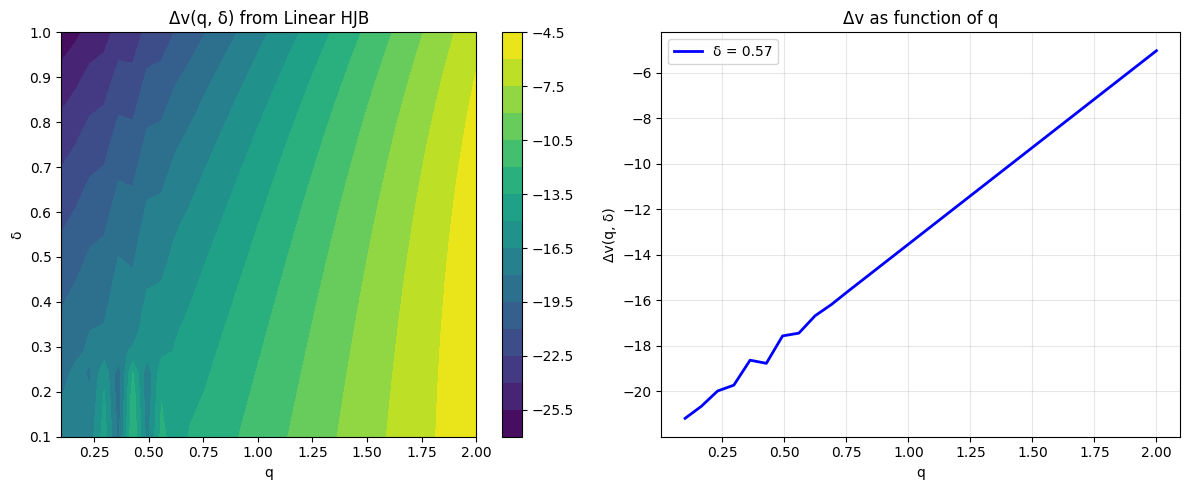

In [40]:
def build_flow_term(a):
    """
    Build the flow term b = vec(q*δ) - (1/2)*vec(κ*a²)
    """
    # Create q*δ matrix
    q_delta = np.zeros((N_q, N_delta))
    for i in range(N_q):
        for j in range(N_delta):
            q_delta[i, j] = q_grid[i] * delta_grid[j]
    
    # Cost term: (1/2) * kappa * a²
    cost_term = 0.5 * kappa[:, None] * (a ** 2)
    
    # Flow term
    b = q_delta - cost_term
    
    # Vectorize (column-major)
    b_vec = b.flatten('F')
    
    return b_vec

# Build flow term
print("Building flow term...")
b = build_flow_term(a)
print(f"Flow term built:")
print(f"  Shape: {b.shape}")
print(f"  Min: {np.min(b):.4f}, Max: {np.max(b):.4f}, Mean: {np.mean(b):.4f}")

# Solve linear HJB
print("\nSolving linear HJB...")
try:
    A = build_HJB_operator(a, h_0, h_1)
    
    # Check matrix condition number for stability
    try:
        from scipy.sparse.linalg import eigsh
        # Get a few eigenvalues to check stability
        eigvals = eigsh(A, k=min(5, A.shape[0]-1), which='SM', return_eigenvectors=False)
        print(f"  Smallest eigenvalues (real part): {np.real(eigvals[:3])}")
        if np.any(np.real(eigvals) < -1e-10):
            print(f"  WARNING: Matrix has negative eigenvalues, may be unstable!")
    except:
        print("  (Could not compute eigenvalues for stability check)")
    
    Delta_v_vec = spsolve(A, b)
    Delta_v_new = Delta_v_vec.reshape((N_q, N_delta), order='F')
    
    # Check for numerical issues
    if np.any(np.isnan(Delta_v_new)) or np.any(np.isinf(Delta_v_new)):
        print(f"  ERROR: Solution contains NaN or Inf!")
        print(f"  Max abs value: {np.nanmax(np.abs(Delta_v_new))}")
    elif np.max(np.abs(Delta_v_new)) > 1e10:
        print(f"  WARNING: Solution has very large values (max = {np.max(np.abs(Delta_v_new)):.2e})")
        print(f"  This suggests numerical instability. Check HJB operator.")
    
    print(f"HJB solved successfully!")
    print(f"  Delta_v shape: {Delta_v_new.shape}")
    print(f"  Delta_v min: {np.min(Delta_v_new):.4f}, max: {np.max(Delta_v_new):.4f}")
    
    # Check residual
    residual = A @ Delta_v_vec - b
    residual_norm = np.max(np.abs(residual))
    print(f"  Residual norm (max): {residual_norm:.2e}")
    
    # Plot solution
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Surface plot
    im = axes[0].contourf(q_grid, delta_grid, Delta_v_new.T, levels=20, cmap='viridis')
    axes[0].set_xlabel('q')
    axes[0].set_ylabel('δ')
    axes[0].set_title('Δv(q, δ) from Linear HJB')
    plt.colorbar(im, ax=axes[0])
    
    # Slice at middle delta
    mid_delta_idx = N_delta // 2
    axes[1].plot(q_grid, Delta_v_new[:, mid_delta_idx], 'b-', linewidth=2, label=f'δ = {delta_grid[mid_delta_idx]:.2f}')
    axes[1].set_xlabel('q')
    axes[1].set_ylabel('Δv(q, δ)')
    axes[1].set_title('Δv as function of q')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Update Delta_v
    Delta_v = Delta_v_new.copy()
    
except Exception as e:
    print(f"Error solving HJB: {e}")
    import traceback
    traceback.print_exc()


## Step 6: Policy Update (FOC Improvement)

Following Section 4, update maintenance policy a using the FOC: c_a(a*, q) = (Δv)_q


Updating policy...
Policy updated:
  a shape: (30, 20)
  a min: 0.0000, max: 100.0000, mean: 15.9143
  Non-zero entries: 568 / 600


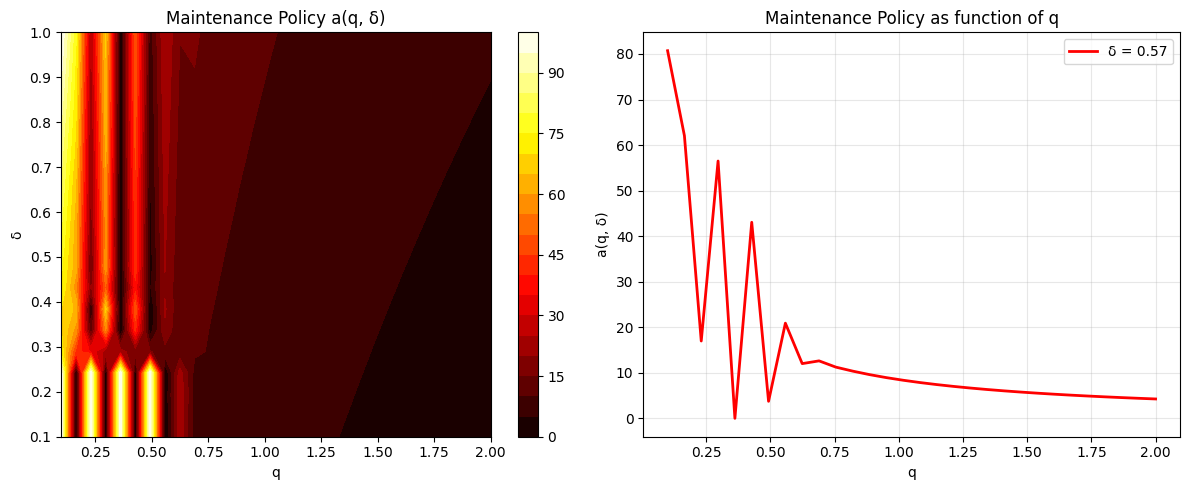

In [41]:
def update_policy(Delta_v, theta=0.5):
    """
    Update maintenance policy using FOC: a* = (1/κ) * (Δv)_q (positive part)
    
    Parameters:
    - Delta_v: reservation value matrix (N_q, N_delta)
    - theta: damping parameter (0 < theta <= 1)
    
    Returns:
    - a_new: updated policy matrix (N_q, N_delta)
    """
    # Compute (Δv)_q using the slope operator S
    Delta_v_vec = Delta_v.flatten('F')
    Delta_v_q_vec = S @ Delta_v_vec
    Delta_v_q = Delta_v_q_vec.reshape((N_q, N_delta), order='F')
    
    # FOC: a* = (1/κ) * (Δv)_q (positive part)
    # Since c(a, q) = (1/2) * κ * a², we have c_a = κ * a
    # So c_a = (Δv)_q implies a = (Δv)_q / κ
    a_new = np.zeros((N_q, N_delta))
    for i in range(N_q):
        for j in range(N_delta):
            a_new[i, j] = max(0, Delta_v_q[i, j] / kappa[i])  # Positive part
    
    # Cap extremely large values to prevent numerical instability
    max_a = 100.0  # Reasonable upper bound
    a_new = np.minimum(a_new, max_a)
    
    return a_new

# Update policy
print("Updating policy...")
try:
    a_new = update_policy(Delta_v, theta=0.5)
    
    print(f"Policy updated:")
    print(f"  a shape: {a_new.shape}")
    print(f"  a min: {np.min(a_new):.4f}, max: {np.max(a_new):.4f}, mean: {np.mean(a_new):.4f}")
    print(f"  Non-zero entries: {np.sum(a_new > 0)} / {a_new.size}")
    
    # Plot policy
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Surface plot
    im = axes[0].contourf(q_grid, delta_grid, a_new.T, levels=20, cmap='hot')
    axes[0].set_xlabel('q')
    axes[0].set_ylabel('δ')
    axes[0].set_title('Maintenance Policy a(q, δ)')
    plt.colorbar(im, ax=axes[0])
    
    # Slice at middle delta
    mid_delta_idx = N_delta // 2
    axes[1].plot(q_grid, a_new[:, mid_delta_idx], 'r-', linewidth=2, label=f'δ = {delta_grid[mid_delta_idx]:.2f}')
    axes[1].set_xlabel('q')
    axes[1].set_ylabel('a(q, δ)')
    axes[1].set_title('Maintenance Policy as function of q')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Update a with damping
    a = 0.5 * a + 0.5 * a_new
    
except Exception as e:
    print(f"Error updating policy: {e}")
    import traceback
    traceback.print_exc()


## Step 7: Build KFE Operators (Owners and Non-Owners)

Following Section 5 of the Appendix, we construct the discrete KFE operators.


In [42]:
def build_KFE_owner_operator(a, h_0_current, h_1_current):
    """
    Build the KFE operator for owners: L_1 (linearized around current h_0, h_1)
    
    The discrete KFE is:
    0 = -div_q((a-dq)h_1) + γ(g*H_1 - h_1) + ρ*h_0*S^<= - ρ*h_1*B^>= 
        + ρ*(I_1 + I_2) - ρ*A*h_1
    
    Note: Some terms depend on h_0 and h_1, so we linearize around current values.
    """
    N = N_q * N_delta
    L_1 = sparse.lil_matrix((N, N))
    
    # 1. Finite-volume divergence in q: -div_q((a-dq)h_1)
    # Following document Section 5: "Finite-volume divergence in q (owners)"
    # The discrete divergence is: -[F_{i+1/2,j} - F_{i-1/2,j}]/Δq
    # where F_{i+1/2,j} = v_{i+1/2,j} * h^{up}_{i+1/2,j}
    # and v_{i+1/2,j} = 0.5*(a_{i,j}+a_{i+1,j}) - d*q_{i+1/2}
    # Boundary conditions: F_{1/2,j} = F_{N_q+1/2,j} = 0 (zero flux)
    for j in range(N_delta):
        for i in range(N_q):
            idx = j * N_q + i
            
            # Right face flux F_{i+1/2,j}
            if i < N_q - 1:
                q_half = 0.5 * (q_grid[i] + q_grid[i+1])
                v_half = 0.5 * (a[i, j] + a[i+1, j]) - d * q_half
                
                # Upwind choice: h^{up} = h_1[i,j] if v>=0, else h_1[i+1,j]
                if v_half >= 0:
                    # Flux from cell i: contributes -v_half/Δq * h_1[i,j] to cell i
                    L_1[idx, idx] -= v_half / Delta_q
                else:
                    # Flux from cell i+1: contributes -v_half/Δq * h_1[i+1,j] to cell i
                    L_1[idx, idx + 1] -= v_half / Delta_q
            # At right boundary (i = N_q-1): F_{N_q+1/2,j} = 0, so no contribution
            
            # Left face flux F_{i-1/2,j}  
            if i > 0:
                q_half = 0.5 * (q_grid[i-1] + q_grid[i])
                v_half = 0.5 * (a[i-1, j] + a[i, j]) - d * q_half
                
                if v_half >= 0:
                    # Flux from cell i-1: contributes +v_half/Δq * h_1[i-1,j] to cell i
                    L_1[idx, idx - 1] += v_half / Delta_q
                else:
                    # Flux from cell i: contributes +v_half/Δq * h_1[i,j] to cell i
                    L_1[idx, idx] += v_half / Delta_q
            # At left boundary (i = 0): F_{1/2,j} = 0, so no contribution
    
    # 2. Type reset: γ(g*H_1 - h_1)
    # H_1(q) = sum_delta h_1(q, delta) * w_delta
    for i in range(N_q):
        for j in range(N_delta):
            idx = j * N_q + i
            # -γ * h_1(q, δ)
            L_1[idx, idx] -= gamma
            # +γ * g(δ') * H_1(q) - this couples all deltas for same q
            for k in range(N_delta):
                idx_k = k * N_q + i
                L_1[idx, idx_k] += gamma * g[k] * w_delta[k]
    
    # 3. Trade terms: ρ*h_0*S^<= - ρ*h_1*B^>=
    # S^<=_{i,j} = sum_{s=1}^j h_{1,i,s} * w_delta_s (depends on h_1_current)
    # B^>=_j = sum_{b=j}^{N_delta} h_{0_current,b} * w_delta_b (fixed from h_0_current)
    B_ge = np.zeros(N_delta)
    for j in range(N_delta):
        B_ge[j] = np.sum(h_0_current[j:] * w_delta[j:])
    
    for i in range(N_q):
        for j in range(N_delta):
            idx = j * N_q + i
            
            # +ρ * h_0_current[j] * sum_{s=1}^j h_1[i,s] * w_delta_s
            # This couples h_1[i, s] for s <= j
            for s in range(j + 1):
                idx_s = s * N_q + i
                L_1[idx, idx_s] += rho * h_0_current[j] * w_delta[s]
            
            # -ρ * h_1[i, j] * B^>=_j
            L_1[idx, idx] -= rho * B_ge[j]
    
    # 4. Swap terms: ρ*(I_1 + I_2) - ρ*A*h_1
    # I_1(i,j) = sum_{i'=i}^{N_q} w_q[i'] * sum_{s=1}^j h_1[i',s] * w_delta_s
    # I_2(i,j) = sum_{i'=1}^i w_q[i'] * sum_{b=j}^{N_delta} h_1[i',b] * w_delta_b
    # A_{i,j} = (q_max - q_i)*(delta_max - delta_j) + (q_i - q_min)*(delta_j - delta_min)
    for i in range(N_q):
        for j in range(N_delta):
            idx = j * N_q + i
            
            # I_1: adds from h_1[i', s] where i' >= i and s <= j
            for i_prime in range(i, N_q):
                for s in range(j + 1):
                    idx_prime = s * N_q + i_prime
                    L_1[idx, idx_prime] += rho * w_q[i_prime] * w_delta[s]
            
            # I_2: adds from h_1[i', b] where i' <= i and b >= j
            for i_prime in range(i + 1):
                for b in range(j, N_delta):
                    idx_prime = b * N_q + i_prime
                    L_1[idx, idx_prime] += rho * w_q[i_prime] * w_delta[b]
            
            # A_{i,j}: subtracts from h_1[i, j]
            A_ij = (q_max - q_grid[i]) * (delta_max - delta_grid[j]) + \
                   (q_grid[i] - q_min) * (delta_grid[j] - delta_min)
            L_1[idx, idx] -= rho * A_ij
    
    return L_1.tocsr()

def build_KFE_nonowner_operator(h_0_current, h_1_current):
    """
    Build the KFE operator for non-owners: L_0 (linearized around current h_0, h_1)
    
    The discrete KFE is:
    0 = γ(g*H_0 - h_0) + ρ*Q*B^>= - ρ*h_0*T^<=
    """
    L_0 = sparse.lil_matrix((N_delta, N_delta))
    
    # 1. Type reset: γ(g*H_0 - h_0)
    # H_0 = sum_delta h_0(delta) * w_delta (depends on h_0_current)
    for j in range(N_delta):
        # -γ * h_0[j]
        L_0[j, j] -= gamma
        # +γ * g[δ'] * H_0 - couples all deltas
        for k in range(N_delta):
            L_0[j, k] += gamma * g[k] * w_delta[k]
    
    # 2. Trade terms: ρ*Q*B^>= - ρ*h_0*T^<=
    # Q_j = sum_i h_1_current[i, j] * w_q[i] (fixed from h_1_current)
    # B^>=_j = sum_{b=j}^{N_delta} h_0[b] * w_delta_b (depends on h_0)
    # T^<=_j = sum_i w_q[i] * sum_{s=1}^j h_1_current[i, s] * w_delta_s (fixed from h_1_current)
    Q = np.zeros(N_delta)
    T_le = np.zeros(N_delta)
    for j in range(N_delta):
        Q[j] = np.sum(h_1_current[:, j] * w_q)
        T_le[j] = np.sum([w_q[i] * np.sum(h_1_current[i, :j+1] * w_delta[:j+1]) for i in range(N_q)])
    
    for j in range(N_delta):
        # +ρ * Q_j * sum_{b=j}^{N_delta} h_0[b] * w_delta_b
        # This couples h_0[b] for b >= j
        for b in range(j, N_delta):
            L_0[j, b] += rho * Q[j] * w_delta[b]
        
        # -ρ * h_0[j] * T^<=_j
        L_0[j, j] -= rho * T_le[j]
    
    return L_0.tocsr()

# Test building KFE operators
print("Building KFE operators...")
try:
    L_1 = build_KFE_owner_operator(a, h_0, h_1)
    print(f"L_1 (owners) built:")
    print(f"  Shape: {L_1.shape}")
    print(f"  Non-zero entries: {L_1.nnz}")
    
    L_0 = build_KFE_nonowner_operator(h_0, h_1)
    print(f"L_0 (non-owners) built:")
    print(f"  Shape: {L_0.shape}")
    print(f"  Non-zero entries: {L_0.nnz}")
    
except Exception as e:
    print(f"Error building KFE operators: {e}")
    import traceback
    traceback.print_exc()


Building KFE operators...
L_1 (owners) built:
  Shape: (600, 600)
  Non-zero entries: 194700
L_0 (non-owners) built:
  Shape: (20, 20)
  Non-zero entries: 400


## Step 8: Solve KFE Equations

Solve the stationary KFE equations using implicit Euler to steady state.


Solving KFE equations...
Solving owners KFE...

Solving non-owners KFE...

KFE solutions:
  h_1 mass: 0.600000 (should be 0.60)
  h_0 mass: 0.400000 (should be 0.40)
  h_1 min: 0.000027, max: 10.414281
  h_0 min: 0.158983, max: 0.743828


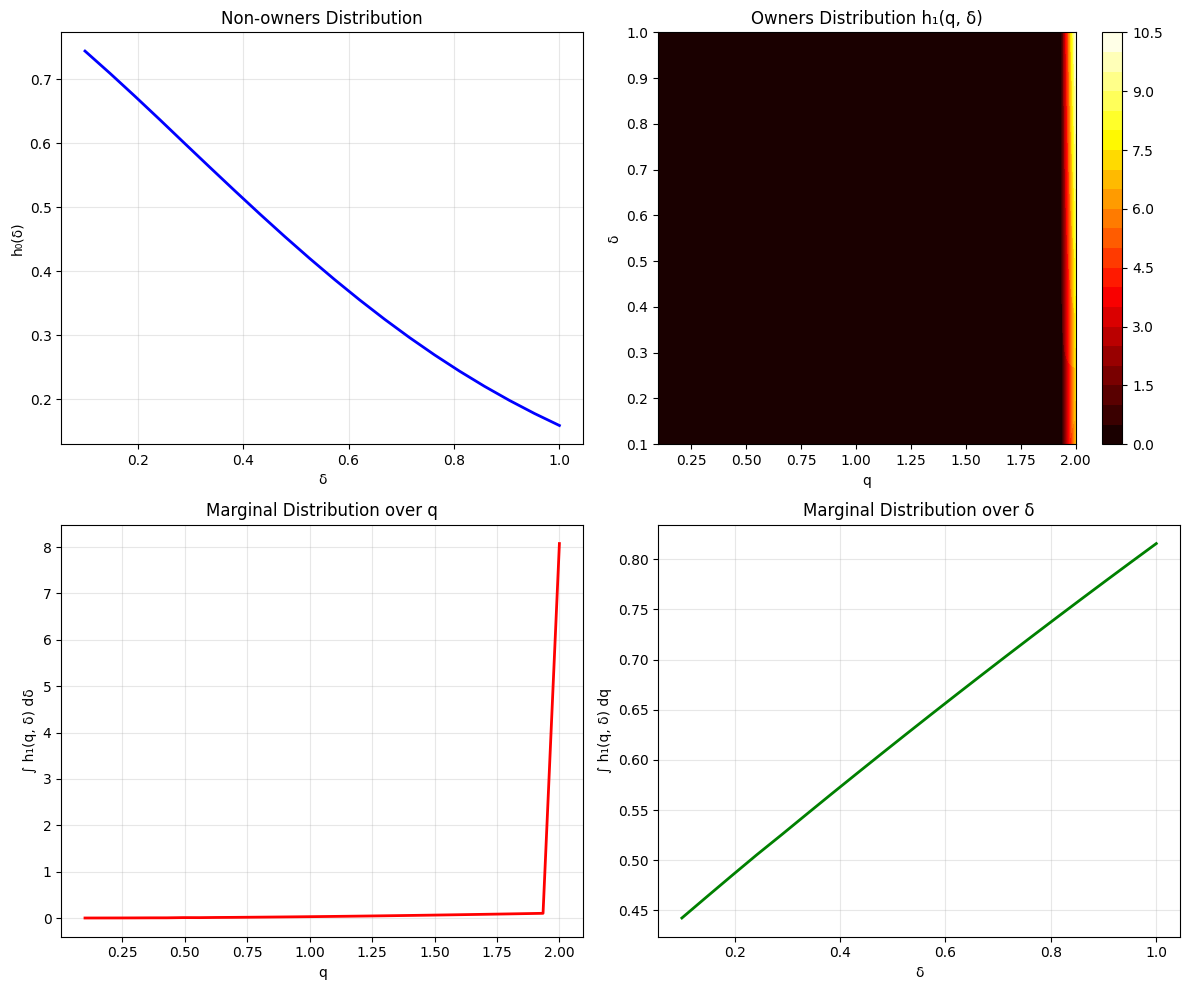

In [43]:
def solve_KFE_owners(a, h_0_current, h_1_current, s_target=None, max_iter=100, dt=0.1, tol=1e-6):
    """
    Solve owners KFE to steady state using implicit Euler with fixed-point iteration.
    
    Parameters:
    - s_target: target mass for owners (defaults to global s_owner)
    """
    if s_target is None:
        s_target = s_owner
    h_1_iter = h_1_current.copy()
    
    for it in range(max_iter):
        # Rebuild operator (linearized around current h_0, h_1)
        L_1 = build_KFE_owner_operator(a, h_0_current, h_1_iter)
        
        # Implicit Euler: (I - dt*L_1) * h_1^{t+1} = h_1^t
        I = sparse.eye(N_q * N_delta)
        h_1_vec = h_1_iter.flatten('F')
        
        try:
            h_1_vec_new = spsolve(I - dt * L_1, h_1_vec)
            h_1_new = h_1_vec_new.reshape((N_q, N_delta), order='F')
            
            # Enforce non-negativity
            h_1_new = np.maximum(h_1_new, 0)
            
            # Check convergence
            diff = np.max(np.abs(h_1_new - h_1_iter))
            if diff < tol:
                if it > 0:
                    print(f"  Owners KFE converged in {it+1} iterations (diff = {diff:.2e})")
                break
            
            # Normalize to satisfy mass constraint: ∫∫ h_1 dq dδ = s_target
            mass = compute_mass_h1(h_1_new)
            if mass > 0:
                h_1_new = h_1_new * (s_target / mass)
            
            h_1_iter = h_1_new
            
        except Exception as e:
            print(f"  Error in iteration {it}: {e}")
            break
    
    return h_1_iter

def solve_KFE_nonowners(h_0_current, h_1_current, s_target=None, max_iter=100, dt=0.1, tol=1e-6):
    """
    Solve non-owners KFE to steady state using implicit Euler with fixed-point iteration.
    
    Parameters:
    - s_target: target mass for owners (defaults to global s_owner, so non-owners = 1-s_target)
    """
    if s_target is None:
        s_target = s_owner
    h_0_target = 1 - s_target
    h_0_iter = h_0_current.copy()
    
    for it in range(max_iter):
        # Rebuild operator (linearized around current h_0, h_1)
        L_0 = build_KFE_nonowner_operator(h_0_iter, h_1_current)
        
        # Implicit Euler: (I - dt*L_0) * h_0^{t+1} = h_0^t
        I = sparse.eye(N_delta)
        
        try:
            h_0_new = spsolve(I - dt * L_0, h_0_iter)
            
            # Enforce non-negativity
            h_0_new = np.maximum(h_0_new, 0)
            
            # Check convergence
            diff = np.max(np.abs(h_0_new - h_0_iter))
            if diff < tol:
                if it > 0:
                    print(f"  Non-owners KFE converged in {it+1} iterations (diff = {diff:.2e})")
                break
            
            # Normalize to satisfy mass constraint: ∫ h_0 dδ = 1 - s_target
            mass = compute_mass_h0(h_0_new)
            if mass > 0:
                h_0_new = h_0_new * (h_0_target / mass)
            
            h_0_iter = h_0_new
            
        except Exception as e:
            print(f"  Error in iteration {it}: {e}")
            break
    
    return h_0_iter

# Solve KFE equations
print("Solving KFE equations...")
try:
    print("Solving owners KFE...")
    h_1_new = solve_KFE_owners(a, h_0, h_1, max_iter=50, dt=0.1, tol=1e-5)
    
    print("\nSolving non-owners KFE...")
    h_0_new = solve_KFE_nonowners(h_0, h_1_new, max_iter=50, dt=0.1, tol=1e-5)
    
    print(f"\nKFE solutions:")
    print(f"  h_1 mass: {compute_mass_h1(h_1_new):.6f} (should be {s_owner:.2f})")
    print(f"  h_0 mass: {compute_mass_h0(h_0_new):.6f} (should be {1-s_owner:.2f})")
    print(f"  h_1 min: {np.min(h_1_new):.6f}, max: {np.max(h_1_new):.6f}")
    print(f"  h_0 min: {np.min(h_0_new):.6f}, max: {np.max(h_0_new):.6f}")
    
    # Plot distributions
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # h_0
    axes[0, 0].plot(delta_grid, h_0_new, 'b-', linewidth=2)
    axes[0, 0].set_xlabel('δ')
    axes[0, 0].set_ylabel('h₀(δ)')
    axes[0, 0].set_title('Non-owners Distribution')
    axes[0, 0].grid(True, alpha=0.3)
    
    # h_1 surface
    im = axes[0, 1].contourf(q_grid, delta_grid, h_1_new.T, levels=20, cmap='hot')
    axes[0, 1].set_xlabel('q')
    axes[0, 1].set_ylabel('δ')
    axes[0, 1].set_title('Owners Distribution h₁(q, δ)')
    plt.colorbar(im, ax=axes[0, 1])
    
    # h_1 marginal over q
    h_1_q_marginal = np.sum(h_1_new * w_delta, axis=1)
    axes[1, 0].plot(q_grid, h_1_q_marginal, 'r-', linewidth=2)
    axes[1, 0].set_xlabel('q')
    axes[1, 0].set_ylabel('∫ h₁(q, δ) dδ')
    axes[1, 0].set_title('Marginal Distribution over q')
    axes[1, 0].grid(True, alpha=0.3)
    
    # h_1 marginal over delta
    h_1_delta_marginal = np.sum(h_1_new * w_q[:, None], axis=0)
    axes[1, 1].plot(delta_grid, h_1_delta_marginal, 'g-', linewidth=2)
    axes[1, 1].set_xlabel('δ')
    axes[1, 1].set_ylabel('∫ h₁(q, δ) dq')
    axes[1, 1].set_title('Marginal Distribution over δ')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Update distributions
    h_1 = h_1_new.copy()
    h_0 = h_0_new.copy()
    
except Exception as e:
    print(f"Error solving KFE: {e}")
    import traceback
    traceback.print_exc()


## Step 9: Main Solution Algorithm (Policy–HJB–KFE Fixed Point)

Following Section 7 of the Appendix, implement the outer policy iteration loop.


Starting main solution algorithm...
Initialization check: s = 0.6, 1-s = 0.4
  Initial h_1 mass: 0.620690 (target: 0.60)
  Initial h_0 mass: 0.400000 (target: 0.40)

Iteration 1/10
Step 1: Solving HJB...
  WARNING in HJB operator: Minimum diagonal = -0.440613 < 0
    This may cause instability. Check implementation.
  HJB residual: 1.98e-13
  Normalized HJB residual: 6.58e-14
Step 2: Updating policy...
  Policy change: 100.0000
  Policy range: [0.0000, 30.0000]
Step 3: Solving KFE...
  Owners KFE change: 6.41e+00
  Owners mass after solve: 0.600000 (target: 0.60)
  Non-owners KFE change: 1.62e-01
  Non-owners mass after solve: 0.400000 (target: 0.40)

Max error: 1.00e+02

Iteration 2/10
Step 1: Solving HJB...
  WARNING in HJB operator: Minimum diagonal = -457.608384 < 0
    This may cause instability. Check implementation.
  HJB residual: 1.61e-10
  Normalized HJB residual: 7.20e-13
Step 2: Updating policy...
  Policy change: 85.1758
  Policy range: [0.5914, 51.0000]
Step 3: Solving KF

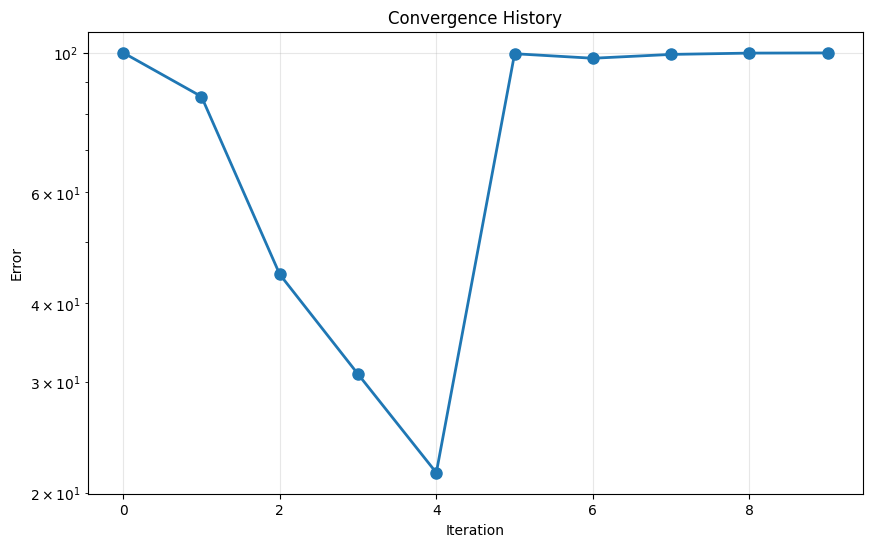

In [44]:
def solve_equilibrium(max_iter=20, tol=1e-4, theta=0.3, howard_steps=3):
    """
    Main solution algorithm: Policy–HJB–KFE fixed point iteration.
    
    Parameters:
    - max_iter: maximum outer iterations
    - tol: convergence tolerance
    - theta: policy damping parameter
    - howard_steps: number of Howard steps (re-solve HJB with fixed policy)
    """
    # Reinitialize - use explicit s_owner to avoid any variable name conflicts
    s_local = s_owner  # Use local variable to ensure correct value
    h_0 = (1 - s_local) * g.copy()
    h_1 = np.zeros((N_q, N_delta))
    for i in range(N_q):
        h_1[i, :] = s_local * g / (q_max - q_min)
    a = np.zeros((N_q, N_delta))
    Delta_v = np.zeros((N_q, N_delta))
    for i in range(N_q):
        for j in range(N_delta):
            Delta_v[i, j] = delta_grid[j] * q_grid[i] / r
    
    # Verify initialization
    print(f"Initialization check: s = {s_local}, 1-s = {1-s_local}")
    print(f"  Initial h_1 mass: {compute_mass_h1(h_1):.6f} (target: {s_local:.2f})")
    print(f"  Initial h_0 mass: {compute_mass_h0(h_0):.6f} (target: {1-s_local:.2f})")
    
    errors = []
    
    for n in range(max_iter):
        print(f"\n{'='*60}")
        print(f"Iteration {n+1}/{max_iter}")
        print(f"{'='*60}")
        
        # 1. HJB (linear) given a, h_0, h_1
        print("Step 1: Solving HJB...")
        try:
            A = build_HJB_operator(a, h_0, h_1)
            b = build_flow_term(a)
            
            # Howard steps: re-solve HJB with fixed policy
            Delta_v_vec = Delta_v.flatten('F')
            for h_step in range(howard_steps):
                Delta_v_vec = spsolve(A, b)
                residual = A @ Delta_v_vec - b
                residual_norm = np.max(np.abs(residual))
                if h_step == 0:
                    print(f"  HJB residual: {residual_norm:.2e}")
            
            Delta_v = Delta_v_vec.reshape((N_q, N_delta), order='F')
            
            # Check HJB residual
            residual = A @ Delta_v_vec - b
            R_HJB = np.max(np.abs(residual)) / (1 + np.max(np.abs(b)))
            print(f"  Normalized HJB residual: {R_HJB:.2e}")
            
        except Exception as e:
            print(f"  ERROR in HJB solve: {e}")
            import traceback
            traceback.print_exc()
            break
        
        # 2. Policy improvement (FOC)
        print("Step 2: Updating policy...")
        try:
            a_new = update_policy(Delta_v, theta=1.0)  # Get undamped update
            a_diff = np.max(np.abs(a_new - a))
            print(f"  Policy change: {a_diff:.4f}")
            
            # Damp policy update
            a = (1 - theta) * a + theta * a_new
            print(f"  Policy range: [{np.min(a):.4f}, {np.max(a):.4f}]")
            
        except Exception as e:
            print(f"  ERROR in policy update: {e}")
            import traceback
            traceback.print_exc()
            break
        
        # 3. KFE (owners and non-owners) given a
        print("Step 3: Solving KFE...")
        try:
            # Solve owners KFE (use current h_0, h_1)
            h_1_new = solve_KFE_owners(a, h_0, h_1, s_target=s_local, max_iter=30, dt=0.1, tol=1e-5)
            R_1 = np.max(np.abs(h_1_new - h_1)) / (1 + np.max(np.abs(h_1)))
            print(f"  Owners KFE change: {R_1:.2e}")
            print(f"  Owners mass after solve: {compute_mass_h1(h_1_new):.6f} (target: {s_local:.2f})")
            
            # Solve non-owners KFE (use updated h_1_new)
            h_0_new = solve_KFE_nonowners(h_0, h_1_new, s_target=s_local, max_iter=30, dt=0.1, tol=1e-5)
            R_0 = np.max(np.abs(h_0_new - h_0)) / (1 + np.max(np.abs(h_0)))
            print(f"  Non-owners KFE change: {R_0:.2e}")
            print(f"  Non-owners mass after solve: {compute_mass_h0(h_0_new):.6f} (target: {1-s_local:.2f})")
            
            h_1 = h_1_new
            h_0 = h_0_new
            
        except Exception as e:
            print(f"  ERROR in KFE solve: {e}")
            import traceback
            traceback.print_exc()
            break
        
        # 4. Convergence test
        error = max(R_HJB, R_1, R_0, a_diff)
        errors.append(error)
        print(f"\nMax error: {error:.2e}")
        
        if error < tol:
            print(f"\n✓ Convergence achieved in {n+1} iterations!")
            break
    
    return Delta_v, a, h_1, h_0, errors

# Run main algorithm
print("Starting main solution algorithm...")
try:
    Delta_v_final, a_final, h_1_final, h_0_final, errors = solve_equilibrium(
        max_iter=10, 
        tol=1e-3, 
        theta=0.3,
        howard_steps=2
    )
    
    print("\n" + "="*60)
    print("SOLUTION COMPLETE")
    print("="*60)
    
    # Plot convergence
    plt.figure(figsize=(10, 6))
    plt.semilogy(errors, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.title('Convergence History')
    plt.grid(True, alpha=0.3)
    plt.show()
    
except Exception as e:
    print(f"Error in main algorithm: {e}")
    import traceback
    traceback.print_exc()


## Step 10: Plot Final Results

Plot the main objects: Δv, a, h₁, h₀


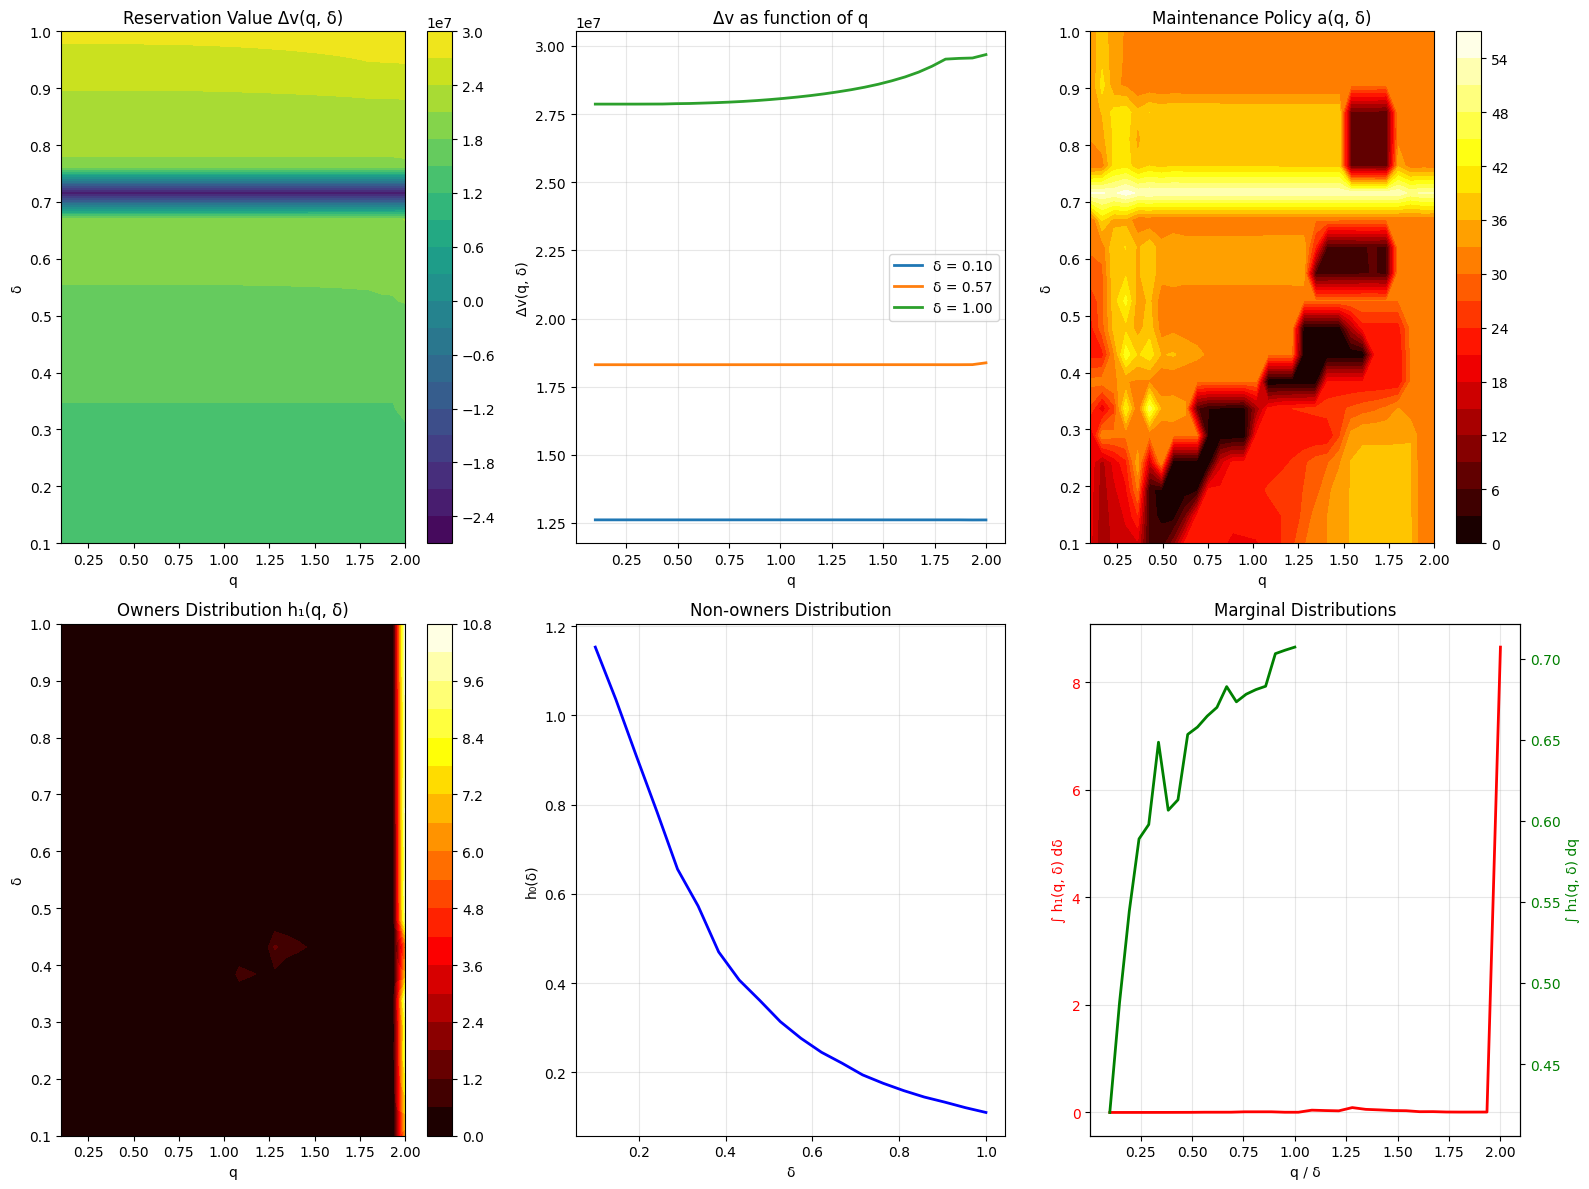


FINAL SOLUTION SUMMARY
Δv: min = -24125191.9607, max = 29681457.8963
a: min = 0.0850, max = 55.6588, mean = 29.0445
h₁: mass = 0.600000 (target: 0.60)
h₀: mass = 0.400000 (target: 0.40)
h₁: min = 0.000041, max = 10.515127
h₀: min = 0.110465, max = 1.152832


In [45]:
# Plot final results
try:
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Delta_v surface
    ax1 = plt.subplot(2, 3, 1)
    im1 = ax1.contourf(q_grid, delta_grid, Delta_v_final.T, levels=20, cmap='viridis')
    ax1.set_xlabel('q')
    ax1.set_ylabel('δ')
    ax1.set_title('Reservation Value Δv(q, δ)')
    plt.colorbar(im1, ax=ax1)
    
    # 2. Delta_v slices
    ax2 = plt.subplot(2, 3, 2)
    for j in [0, N_delta//2, N_delta-1]:
        ax2.plot(q_grid, Delta_v_final[:, j], linewidth=2, 
                label=f'δ = {delta_grid[j]:.2f}')
    ax2.set_xlabel('q')
    ax2.set_ylabel('Δv(q, δ)')
    ax2.set_title('Δv as function of q')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Maintenance policy a
    ax3 = plt.subplot(2, 3, 3)
    im3 = ax3.contourf(q_grid, delta_grid, a_final.T, levels=20, cmap='hot')
    ax3.set_xlabel('q')
    ax3.set_ylabel('δ')
    ax3.set_title('Maintenance Policy a(q, δ)')
    plt.colorbar(im3, ax=ax3)
    
    # 4. Owners distribution h_1
    ax4 = plt.subplot(2, 3, 4)
    im4 = ax4.contourf(q_grid, delta_grid, h_1_final.T, levels=20, cmap='hot')
    ax4.set_xlabel('q')
    ax4.set_ylabel('δ')
    ax4.set_title('Owners Distribution h₁(q, δ)')
    plt.colorbar(im4, ax=ax4)
    
    # 5. Non-owners distribution h_0
    ax5 = plt.subplot(2, 3, 5)
    ax5.plot(delta_grid, h_0_final, 'b-', linewidth=2)
    ax5.set_xlabel('δ')
    ax5.set_ylabel('h₀(δ)')
    ax5.set_title('Non-owners Distribution')
    ax5.grid(True, alpha=0.3)
    
    # 6. Marginal distributions
    ax6 = plt.subplot(2, 3, 6)
    h_1_q_marginal = np.sum(h_1_final * w_delta, axis=1)
    h_1_delta_marginal = np.sum(h_1_final * w_q[:, None], axis=0)
    
    ax6_twin = ax6.twinx()
    line1 = ax6.plot(q_grid, h_1_q_marginal, 'r-', linewidth=2, label='Marginal over q')
    ax6.set_xlabel('q / δ')
    ax6.set_ylabel('∫ h₁(q, δ) dδ', color='r')
    ax6.tick_params(axis='y', labelcolor='r')
    
    line2 = ax6_twin.plot(delta_grid, h_1_delta_marginal, 'g-', linewidth=2, label='Marginal over δ')
    ax6_twin.set_ylabel('∫ h₁(q, δ) dq', color='g')
    ax6_twin.tick_params(axis='y', labelcolor='g')
    
    ax6.set_title('Marginal Distributions')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("FINAL SOLUTION SUMMARY")
    print("="*60)
    print(f"Δv: min = {np.min(Delta_v_final):.4f}, max = {np.max(Delta_v_final):.4f}")
    print(f"a: min = {np.min(a_final):.4f}, max = {np.max(a_final):.4f}, mean = {np.mean(a_final):.4f}")
    print(f"h₁: mass = {compute_mass_h1(h_1_final):.6f} (target: {s_owner:.2f})")
    print(f"h₀: mass = {compute_mass_h0(h_0_final):.6f} (target: {1-s_owner:.2f})")
    print(f"h₁: min = {np.min(h_1_final):.6f}, max = {np.max(h_1_final):.6f}")
    print(f"h₀: min = {np.min(h_0_final):.6f}, max = {np.max(h_0_final):.6f}")
    
except Exception as e:
    print(f"Error plotting results: {e}")
    import traceback
    traceback.print_exc()
